In [1]:
# import numpy as np
# import pandas as pd
# from pandas.tseries.offsets import MonthEnd

# # raw_data = pd.read_excel(
# #     "/Users/drest/Downloads/Book2.xlsx",
# #     sheet_name="Country_Avg",
# # )

# # # Unpivot the DataFrame so each year/month is a row, not a column
# # raw_data = raw_data.melt(id_vars=["Unnamed: 0"], var_name="year", value_name="value")
# # raw_data = raw_data.rename(columns={"Unnamed: 0": "month"})

# # raw_data["eom"] = pd.to_datetime(raw_data["year"].astype(str) + "-" + raw_data["month"].astype(str).str.strip() + "-01", format="%Y-%b-%d") + MonthEnd(0)
# # raw_data.drop(columns=["year", "month"], inplace=True)
# # weekly_data = pd.read_parquet(".data/extracted/porkcolombia.parquet.snappy")
# # weekly_data = weekly_data.loc[weekly_data["ts"] >= pd.to_datetime("2023-12-31")]
# # weekly_data["eom"] = weekly_data["ts"] + MonthEnd(0)
# # weekly_data_ = weekly_data.groupby("eom").agg({"average": "mean"}).reset_index().sort_values("eom", ascending=False)
# # combined = raw_data.merge(weekly_data_, on="eom", how="left")
# # combined["price"] = combined[["value", "average"]].mean(axis=1, skipna=True)
# # combined.drop(columns=["value", "average"], inplace=True)
# # combined.sort_values("eom", ascending=False, inplace=True)
# # combined.reset_index(drop=True).to_parquet(".data/extracted/porkcolombia_country_avg.parquet.snappy", index=False)
# country_avg = pd.read_parquet(".data/extracted/porkcolombia_country_avg.parquet.snappy")
# regional_data = pd.read_excel(
#     "/Users/drest/Downloads/Book2.xlsx",
#     sheet_name="Regional",
# )
# regional_data.fillna(method="ffill", inplace=True)
# antioquia = regional_data[["Mes", "Antioquia"]].rename(columns={"Mes": "eom", "Antioquia": "price"})
# antioquia["eom"] = antioquia["eom"] + MonthEnd(0)
# antioquia = antioquia.sort_values("eom", ascending=False).reset_index(drop=True).set_index("eom")
# antioquia.loc[pd.to_datetime("2025-12-31"), "price"] = 8_126
# antioquia.loc[:, "series_id"] = "Antioquia"
# country_avg.loc[:, "series_id"] = "Country_Avg"
# antioquia.reset_index(inplace=True)
# price_data = pd.concat([antioquia, country_avg], ignore_index=True, axis=0).sort_values(["series_id", "eom"], ascending=False).reset_index(drop=True)


# import pandas as pd
# from pandas.tseries.offsets import MonthEnd


# raw_country_production_data = pd.read_excel(
#     "/Users/drest/Downloads/Book2.xlsx",
#     sheet_name="Country_production_avg",
# )

# unpivoted_country_production_data = raw_country_production_data.melt(id_vars=["Mes"], var_name="year", value_name="value").rename(columns={"Mes": "month"})
# unpivoted_country_production_data["eom"] = pd.to_datetime(unpivoted_country_production_data["year"].astype(str) + "-" + unpivoted_country_production_data["month"].astype(str).str.strip() + "-01", format="%Y-%b-%d") + MonthEnd(0)
# unpivoted_country_production_data.drop(columns=["year", "month"], inplace=True)
# unpivoted_country_production_data.rename(columns={"value": "production"}, inplace=True)
# unpivoted_country_production_data.sort_values("eom", ascending=False, inplace=True)
# unpivoted_country_production_data.reset_index(drop=True, inplace=True)
# unpivoted_country_production_data.loc[:, "series_id"] = "Country_Avg"

# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.linear_model import LinearRegression

# # Prepare data for polynomial regression
# country_production_sorted = unpivoted_country_production_data.sort_values("eom").reset_index(drop=True)
# country_production_sorted["numeric_time"] = (country_production_sorted["eom"] - country_production_sorted["eom"].min()).dt.days
# X_train = country_production_sorted["numeric_time"].values.reshape(-1, 1)
# y_train = country_production_sorted["production"].astype(float).values

# # Remove NaN values, if any
# mask_not_nan = ~pd.isna(y_train)
# X_train = X_train[mask_not_nan]
# y_train = y_train[mask_not_nan]

# poly = PolynomialFeatures(degree=3)
# X_poly = poly.fit_transform(X_train)

# model = LinearRegression()
# model.fit(X_poly, y_train)

# # Predict for 2025-12-31
# target_date = pd.to_datetime("2025-12-31")
# target_numeric_time = (target_date - country_production_sorted["eom"].min()).days
# X_pred = poly.transform([[target_numeric_time]])
# production_2025_12_31 = model.predict(X_pred)[0]

# # Optionally, append to DataFrame (if needed for downstream use)
# predicted_row = {
#     "eom": target_date,
#     "production": production_2025_12_31,
#     "series_id": "Country_Avg"
# }
# unpivoted_country_production_data = pd.concat([
#     unpivoted_country_production_data,
#     pd.DataFrame([predicted_row])
# ], ignore_index=True).dropna()

# raw_regional_production_data = pd.read_excel(
#     "/Users/drest/Downloads/Book2.xlsx",
#     sheet_name="Regional_production_avg",
# )

# regional_production_data = raw_regional_production_data.T
# regional_production_data.columns = regional_production_data.iloc[0]
# regional_production_data.drop(regional_production_data.index[0], inplace=True)
# regional_production_data.reset_index(inplace=True)
# regional_production_data.rename(columns={"index": "month"}, inplace=True)
# regional_production_data["eom"] = pd.to_datetime(regional_production_data["month"].astype(str).str.strip()) + MonthEnd(0)
# regional_production_data.drop(columns=["month"], inplace=True)
# regional_production_data = regional_production_data[["eom", "Antioquia"]].rename(columns={"Antioquia": "production"})
# regional_production_data.loc[:, "series_id"] = "Antioquia"

# regional_production_data.columns.name = None
# regional_production_data.index.name = None
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.linear_model import LinearRegression

# # Prepare data for autoregression (polynomial)
# regional_production_data_sorted = regional_production_data.sort_values("eom").reset_index(drop=True)

# # Use only numeric index as time to predict next value at t+1 (2025-12-31)
# regional_production_data_sorted['numeric_time'] = (regional_production_data_sorted['eom'] - regional_production_data_sorted['eom'].min()).dt.days

# # Use all but last for X_train, and corresponding for y_train
# X_train = regional_production_data_sorted['numeric_time'].values.reshape(-1, 1)
# y_train = regional_production_data_sorted['production'].astype(float).values

# # Remove missing (NaN) production data, just in case
# mask_not_nan = ~pd.isna(y_train)
# X_train = X_train[mask_not_nan]
# y_train = y_train[mask_not_nan]

# # Polynomial features (degree can be changed as needed)
# poly = PolynomialFeatures(degree=3)
# X_poly = poly.fit_transform(X_train)

# model = LinearRegression()
# model.fit(X_poly, y_train)

# # Predict for 2025-12-31
# target_date = pd.to_datetime("2025-12-31")
# target_numeric_time = (target_date - regional_production_data_sorted['eom'].min()).days
# X_pred = poly.transform([[target_numeric_time]])
# predicted_production = model.predict(X_pred)[0]

# # Insert the prediction for 2025-12-31 if it's not there
# if not (regional_production_data_sorted['eom'] == target_date).any():
#     # Insert at the end
#     new_row = pd.DataFrame({
#         'eom': [target_date],
#         'production': [predicted_production],
#         'series_id': ["Antioquia"]
#     })
#     # Ensure columns match (add missing ones if necessary)
#     for col in regional_production_data_sorted.columns:
#         if col not in new_row.columns:
#             new_row[col] = [None]
#     regional_production_data = pd.concat([regional_production_data, new_row[regional_production_data.columns]], ignore_index=True)


# regional_production_data.sort_values("eom", ascending=False, inplace=True)
# regional_production_data.reset_index(drop=True, inplace=True, names=None)
# regional_production_data
# production_data = pd.concat([unpivoted_country_production_data, regional_production_data], ignore_index=True, axis=0).sort_values(["series_id", "eom"], ascending=False).reset_index(drop=True)
# production_data

# combined = pd.merge(price_data, production_data, on=["eom", "series_id"], how="inner")

# raw_consumption_data = pd.read_excel(
#     "/Users/drest/Downloads/Book2.xlsx",
#     sheet_name="Consumption",
# )

# raw_consumption_data
# from sklearn.linear_model import LinearRegression
# import numpy as np

# # Prepare the data for regression
# consumption_df = raw_consumption_data.copy()
# X = consumption_df[['year']].values
# y = consumption_df['per_capita_consumption'].values

# # Fit the linear regression model
# model = LinearRegression()
# model.fit(X, y)

# # Predict per capita consumption for 2025
# year_2025 = np.array([[2025]])
# per_capita_2025 = model.predict(year_2025)[0]

# print(f"Predicted per_capita_consumption for 2025: {per_capita_2025:.2f}")

# raw_consumption_data.loc[len(raw_consumption_data.index)] = pd.Series({"year": 2025, "per_capita_consumption": per_capita_2025})
# raw_consumption_data.sort_values("year", ascending=True, inplace=True)
# raw_consumption_data.reset_index(drop=True, inplace=True)

# import pandas as pd
# import numpy as np
# from pandas.tseries.offsets import MonthEnd

# # Create a monthly date range from the first year to the last year
# monthly_dates = pd.date_range(
#     start=f"{raw_consumption_data['year'].min().astype(int)}-01-01", 
#     end=f"{raw_consumption_data['year'].max().astype(int)}-12-31", 
#     freq='M'
# )
# monthly_consumption_data = pd.DataFrame({
#     'eom': monthly_dates + MonthEnd(0),
#     'year': monthly_dates.year,
# })
# raw_monthly_consumption_data = pd.merge(monthly_consumption_data, raw_consumption_data, on="year", how="left").drop(columns=["year"]).sort_values("eom", ascending=False).reset_index(drop=True)

# regional_monthly_consumption_data = raw_monthly_consumption_data.copy()
# regional_monthly_consumption_data.loc[:, "series_id"] = "Antioquia"
# country_monthly_consumption_data = raw_monthly_consumption_data.copy()
# country_monthly_consumption_data.loc[:, "series_id"] = "Country_Avg"

# consumption_data = pd.concat([regional_monthly_consumption_data, country_monthly_consumption_data], ignore_index=True, axis=0).sort_values(["series_id", "eom"], ascending=False).reset_index(drop=True)
# consumption_data

# combined = pd.merge(combined, consumption_data, on=["eom", "series_id"], how="left")
# combined = combined.loc[combined["eom"] >= pd.to_datetime("2020-01-01")]
# combined.to_parquet(".data/extracted/porkcolombia_combined.parquet.snappy", index=False)
# combined

In [2]:
import pandas as pd
import numpy as np

combined = pd.read_parquet(".data/extracted/porkcolombia_combined.parquet.snappy")
combined["year"] = combined["eom"].dt.year
combined["month"] = combined["eom"].dt.month
combined["time_idx"] = combined.groupby("series_id").cumcount(ascending=False)
combined["price"] = combined["price"].astype(np.float64)
combined["production"] = combined["production"].astype(np.float64)
combined["per_capita_consumption"] = combined["per_capita_consumption"].astype(np.float64)
combined["per_capita_consumption"] = combined["per_capita_consumption"] * combined["price"]
combined.sort_values(["eom"], ascending=True, inplace=True)
combined.reset_index(drop=True, inplace=True)
combined = combined.loc[combined["eom"] >= pd.to_datetime("2020-01-01")]

combined.loc[(combined["eom"] == pd.to_datetime("2025-12-31")) & (combined["series_id"] == "Country_Avg"), ["price", "production", "per_capita_consumption", "year", "month", "time_idx"]] = (8_258, 552691.043067, 120674.584286, 2025, 12, 71)
combined.loc[(combined["eom"] == pd.to_datetime("2025-12-31")) & (combined["series_id"] == "Antioquia"), ["price", "production", "per_capita_consumption", "year", "month", "time_idx"]] = (8_203, 35719.670365, 121704.262857, 2025, 12, 71)
combined = pd.concat([
    combined,
    pd.DataFrame([
        {"eom": pd.to_datetime("2026-01-31"), "series_id": "Country_Avg", "price": 8_321, "production": 552691.043067, "per_capita_consumption": 120674.584286, "year": 2026, "month": 1, "time_idx": 72},
        {"eom": pd.to_datetime("2026-01-31"), "series_id": "Antioquia", "price": 8_126, "production": 35719.670365, "per_capita_consumption": 121704.262857, "year": 2026, "month": 1, "time_idx": 72},
    ]),
], ignore_index=True).sort_values(["time_idx"], ascending=True)

combined

,eom,price,series_id,production,per_capita_consumption,year,month,time_idx
0,2020-01-31,5743.81950,Country_Avg,397678.000000,62033.250600,2020,1,0
1,2020-01-31,5793.00000,Antioquia,173690.000000,62564.400000,2020,1,0
2,2020-02-29,5587.00000,Antioquia,169729.000000,60339.600000,2020,2,1
3,2020-02-29,5566.55125,Country_Avg,384857.000000,60118.753500,2020,2,1
4,2020-03-31,5369.35450,Country_Avg,384485.000000,57989.028600,2020,3,2
...,...,...,...,...,...,...,...,...
141,2025-11-30,7937.00000,Antioquia,231870.000000,118873.582857,2025,11,70
142,2025-12-31,8203.00000,Antioquia,35719.670365,121704.262857,2025,12,71
143,2025-12-31,8258.00000,Country_Avg,552691.043067,120674.584286,2025,12,71
144,2026-01-31,8321.00000,Country_Avg,552691.043067,120674.584286,2026,1,72


In [3]:
# from ts_piggies.forecast.tft import TFTConfig, TFTForecastWrapper
# from ts_piggies.helpers.scaler import MinMaxScalerWrapper

# minmax_scaler = MinMaxScalerWrapper()
# combined_scaled = minmax_scaler.fit_transform(combined, ["price", "production", "per_capita_consumption"])

# wrapper = TFTForecastWrapper(
#     combined_scaled,
#     TFTConfig(
#         learning_rate=0.003,
#         hidden_size=64,
#         attention_head_size=8,
#         dropout=0.01,
#         hidden_continuous_size=64,
#         batch_size=32,
#         max_epochs=100,
#         gradient_clip_val=0.01,
#         reduce_on_plateau_patience=10,
#     ),
#     max_encoder_length=64,
#     max_prediction_length=7,
# )

# result = wrapper.fit_predict(simulations=True)

# results = pd.DataFrame({"eom": result.dates, "price": result.mean})

# results = minmax_scaler.inverse_transform(results, ["price"])

# correction = combined.iloc[-1]["price"] - results.iloc[0]["price"]
# results["price"] = results["price"].astype(np.float64) + correction

# results

In [4]:
import logging
from ts_piggies.helpers.scaler import MinMaxScalerWrapper
from ts_piggies.forecast.grid import ErrorMetric, GridSearch, GridSearchConfig, SimulationsGrid
from ts_piggies.forecast.tft import TFTConfig, TFTForecastWrapper

logger = logging.getLogger("ts_piggies")
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

max_encoder_length = 32
max_prediction_length = 7

minmax_scaler = MinMaxScalerWrapper()
combined_scaled = minmax_scaler.fit_transform(combined, ["price", "production", "per_capita_consumption"])

custom_grid = {
    "learning_rate": [0.005, 0.015],  # 7 values - expanded range
    "hidden_size": [128, 256, 512],  # 4 values - includes smaller and larger models
    "attention_head_size": [4, 6, 8],  # 4 values - varied attention mechanisms
    "dropout": [0.15, 0.2],  # 5 values - regularization range
    "hidden_continuous_size": [32, 64],  # 4 values - continuous feature processing
    "batch_size": [16, 32, 64],  # 3 values - different batch sizes
    "max_epochs": [150, 300],  # 5 values - training duration variation
    "gradient_clip_val": [0.1, 0.15, 0.2],  # 4 values - gradient clipping
    "reduce_on_plateau_patience": [4, 8, 10],  # 3 values - learning rate scheduling
}

grid_config = GridSearchConfig(
    config_type=TFTConfig,
    model_type=TFTForecastWrapper,
    hyperparameter_grid=custom_grid,
    segment_columns=["series_id"],
    sort_columns=["eom"],
    test_column="price",
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    n_simulations=1000,
    error_metric=ErrorMetric.MAPE,
    validation_length=0.15,
)

# Initialize grid search
# grid_search = GridSearch(
#     data=combined_scaled,
#     config=grid_config,
# )

# forecast_results = grid_search.search(max_models=30, random_sample=True).fit_predict()

simulations_grid = SimulationsGrid(
    data=combined_scaled,
    config=grid_config,
)

forecast_results = simulations_grid.search(max_models=50, random_sample=True).fit_predict()


/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/pytorch_forecasting/models/base/_base_model.py:28: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
Running simulation on iteration 1 of 50
Using config: learning_rate=0.015 batch_size=32 max_epochs=300 hidden_size=256 attention_head_size=4 dropout=0.15 hidden_continuous_size=32 gradient_clip_val=0.1 reduce_on_plateau_patience=4
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packag

Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.97it/s, train_loss_step=0.466, train_loss_epoch=0.215]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 299: 100%|██████████| 2/2 [00:00<00:00,  9.38it/s, train_loss_step=0.00212, train_loss_epoch=0.00235]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 2/2 [00:00<00:00,  9.32it/s, train_loss_step=0.00212, train_loss_epoch=0.00235]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pyto

Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.52it/s, train_loss_step=0.0727, train_loss_epoch=0.136]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  8.97it/s, train_loss_step=0.00396, train_loss_epoch=0.0042] 

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  8.94it/s, train_loss_step=0.00396, train_loss_epoch=0.0042]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 3 of 50
Using config: learning_rate=0.005 batch_size=64 max_epochs=300 hidden_size=128 attention_head_size=4 dropout=0.15 hidden_continuous_size=64 gradient_clip_val=0.15 reduce_on_plateau_patience=4
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/li

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.0995, train_loss_epoch=0.0995]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  8.34it/s, train_loss_step=0.00589, train_loss_epoch=0.00589]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  8.27it/s, train_loss_step=0.00589, train_loss_epoch=0.00589]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 4 of 50
Using config: learning_rate=0.015 batch_size=16 max_epochs=300 hidden_size=256 attention_head_size=8 dropout=0.15 hidden_continuous_size=32 gradient_clip_val=0.15 reduce_on_plateau_patience=8
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/li

Epoch 1:  20%|██        | 1/5 [00:00<00:00,  9.14it/s, train_loss_step=0.117, train_loss_epoch=0.235]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 299: 100%|██████████| 5/5 [00:00<00:00,  9.46it/s, train_loss_step=0.00393, train_loss_epoch=0.00344]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 5/5 [00:00<00:00,  9.45it/s, train_loss_step=0.00393, train_loss_epoch=0.00344]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 5 of 50
Using config: learning_rate=0.005 batch_size=64 max_epochs=300 hidden_size=256 attention_head_size=8 dropout=0.15 hidden_continuous_size=32 gradient_clip_val=0.1 reduce_on_plateau_patience=8
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lig

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.105, train_loss_epoch=0.105]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  8.27it/s, train_loss_step=0.00411, train_loss_epoch=0.00411]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  8.21it/s, train_loss_step=0.00411, train_loss_epoch=0.00411]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 6 of 50
Using config: learning_rate=0.005 batch_size=32 max_epochs=300 hidden_size=256 attention_head_size=6 dropout=0.2 hidden_continuous_size=32 gradient_clip_val=0.15 reduce_on_plateau_patience=8
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lig

Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.97it/s, train_loss_step=0.207, train_loss_epoch=0.189]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 299: 100%|██████████| 2/2 [00:00<00:00,  8.87it/s, train_loss_step=0.00421, train_loss_epoch=0.00438]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 2/2 [00:00<00:00,  8.84it/s, train_loss_step=0.00421, train_loss_epoch=0.00438]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 7 of 50
Using config: learning_rate=0.005 batch_size=64 max_epochs=300 hidden_size=256 attention_head_size=6 dropout=0.15 hidden_continuous_size=32 gradient_clip_val=0.15 reduce_on_plateau_patience=10
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/l

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.211, train_loss_epoch=0.211]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  7.87it/s, train_loss_step=0.00552, train_loss_epoch=0.00552]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  7.81it/s, train_loss_step=0.00552, train_loss_epoch=0.00552]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 8 of 50
Using config: learning_rate=0.005 batch_size=32 max_epochs=300 hidden_size=128 attention_head_size=8 dropout=0.2 hidden_continuous_size=32 gradient_clip_val=0.15 reduce_on_plateau_patience=8
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lig

Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, train_loss_step=0.116, train_loss_epoch=0.140] 

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 299: 100%|██████████| 2/2 [00:00<00:00,  9.44it/s, train_loss_step=0.00299, train_loss_epoch=0.00313]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 2/2 [00:00<00:00,  9.40it/s, train_loss_step=0.00299, train_loss_epoch=0.00313]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 9 of 50
Using config: learning_rate=0.015 batch_size=64 max_epochs=300 hidden_size=256 attention_head_size=6 dropout=0.2 hidden_continuous_size=64 gradient_clip_val=0.1 reduce_on_plateau_patience=8
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/ligh

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.159, train_loss_epoch=0.159]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  7.40it/s, train_loss_step=0.00564, train_loss_epoch=0.00564]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  7.35it/s, train_loss_step=0.00564, train_loss_epoch=0.00564]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 10 of 50
Using config: learning_rate=0.005 batch_size=64 max_epochs=150 hidden_size=128 attention_head_size=6 dropout=0.2 hidden_continuous_size=64 gradient_clip_val=0.15 reduce_on_plateau_patience=10
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/l

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.0731, train_loss_epoch=0.0731]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  9.03it/s, train_loss_step=0.00426, train_loss_epoch=0.00426]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  8.96it/s, train_loss_step=0.00426, train_loss_epoch=0.00426]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 11 of 50
Using config: learning_rate=0.015 batch_size=16 max_epochs=300 hidden_size=256 attention_head_size=4 dropout=0.2 hidden_continuous_size=64 gradient_clip_val=0.2 reduce_on_plateau_patience=10
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/li

Epoch 1:  20%|██        | 1/5 [00:00<00:00, 10.18it/s, train_loss_step=0.136, train_loss_epoch=0.243]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 299: 100%|██████████| 5/5 [00:00<00:00, 10.14it/s, train_loss_step=0.00198, train_loss_epoch=0.00183]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 5/5 [00:00<00:00, 10.12it/s, train_loss_step=0.00198, train_loss_epoch=0.00183]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 12 of 50
Using config: learning_rate=0.015 batch_size=16 max_epochs=300 hidden_size=256 attention_head_size=8 dropout=0.15 hidden_continuous_size=32 gradient_clip_val=0.1 reduce_on_plateau_patience=4
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/li

Epoch 1:  20%|██        | 1/5 [00:00<00:00,  9.87it/s, train_loss_step=0.214, train_loss_epoch=0.234]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 299: 100%|██████████| 5/5 [00:00<00:00,  9.46it/s, train_loss_step=0.00192, train_loss_epoch=0.00208]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 5/5 [00:00<00:00,  9.44it/s, train_loss_step=0.00192, train_loss_epoch=0.00208]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 13 of 50
Using config: learning_rate=0.015 batch_size=64 max_epochs=150 hidden_size=512 attention_head_size=6 dropout=0.2 hidden_continuous_size=64 gradient_clip_val=0.1 reduce_on_plateau_patience=4
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lig

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.226, train_loss_epoch=0.226]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  7.86it/s, train_loss_step=0.015, train_loss_epoch=0.015]  

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  7.81it/s, train_loss_step=0.015, train_loss_epoch=0.015]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 14 of 50
Using config: learning_rate=0.015 batch_size=32 max_epochs=150 hidden_size=128 attention_head_size=6 dropout=0.15 hidden_continuous_size=64 gradient_clip_val=0.1 reduce_on_plateau_patience=8
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/li

Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  9.33it/s, train_loss_step=0.222, train_loss_epoch=0.169]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  9.16it/s, train_loss_step=0.00371, train_loss_epoch=0.0041] 

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  9.12it/s, train_loss_step=0.00371, train_loss_epoch=0.0041]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 15 of 50
Using config: learning_rate=0.005 batch_size=32 max_epochs=300 hidden_size=128 attention_head_size=6 dropout=0.2 hidden_continuous_size=32 gradient_clip_val=0.15 reduce_on_plateau_patience=10
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/l

Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.20it/s, train_loss_step=0.131, train_loss_epoch=0.126] 

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 299: 100%|██████████| 2/2 [00:00<00:00,  9.52it/s, train_loss_step=0.00385, train_loss_epoch=0.00345]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 2/2 [00:00<00:00,  9.48it/s, train_loss_step=0.00385, train_loss_epoch=0.00345]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 16 of 50
Using config: learning_rate=0.015 batch_size=64 max_epochs=150 hidden_size=128 attention_head_size=8 dropout=0.15 hidden_continuous_size=32 gradient_clip_val=0.2 reduce_on_plateau_patience=4
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/li

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.199, train_loss_epoch=0.199]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  8.19it/s, train_loss_step=0.00675, train_loss_epoch=0.00675]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  8.13it/s, train_loss_step=0.00675, train_loss_epoch=0.00675]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 17 of 50
Using config: learning_rate=0.005 batch_size=16 max_epochs=150 hidden_size=512 attention_head_size=8 dropout=0.15 hidden_continuous_size=32 gradient_clip_val=0.1 reduce_on_plateau_patience=4
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/li

Epoch 1:  40%|████      | 2/5 [00:00<00:00, 10.35it/s, train_loss_step=0.154, train_loss_epoch=0.223]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 5/5 [00:00<00:00,  9.18it/s, train_loss_step=0.00349, train_loss_epoch=0.00339]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 5/5 [00:00<00:00,  9.16it/s, train_loss_step=0.00349, train_loss_epoch=0.00339]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 18 of 50
Using config: learning_rate=0.005 batch_size=32 max_epochs=150 hidden_size=128 attention_head_size=4 dropout=0.2 hidden_continuous_size=32 gradient_clip_val=0.15 reduce_on_plateau_patience=8
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/li

Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.69it/s, train_loss_step=0.0872, train_loss_epoch=0.163]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  9.74it/s, train_loss_step=0.00875, train_loss_epoch=0.00624]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  9.69it/s, train_loss_step=0.00875, train_loss_epoch=0.00624]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 19 of 50
Using config: learning_rate=0.005 batch_size=16 max_epochs=300 hidden_size=128 attention_head_size=4 dropout=0.2 hidden_continuous_size=32 gradient_clip_val=0.15 reduce_on_plateau_patience=10
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/l

Epoch 1:  20%|██        | 1/5 [00:00<00:00,  9.59it/s, train_loss_step=0.0626, train_loss_epoch=0.0988]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 299: 100%|██████████| 5/5 [00:00<00:00,  9.82it/s, train_loss_step=0.00204, train_loss_epoch=0.00215]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 5/5 [00:00<00:00,  9.80it/s, train_loss_step=0.00204, train_loss_epoch=0.00215]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 20 of 50
Using config: learning_rate=0.005 batch_size=16 max_epochs=150 hidden_size=128 attention_head_size=6 dropout=0.2 hidden_continuous_size=64 gradient_clip_val=0.15 reduce_on_plateau_patience=10
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/l

Epoch 1:  20%|██        | 1/5 [00:00<00:00,  9.97it/s, train_loss_step=0.0609, train_loss_epoch=0.111]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 5/5 [00:00<00:00, 10.05it/s, train_loss_step=0.00332, train_loss_epoch=0.00317]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 5/5 [00:00<00:00, 10.03it/s, train_loss_step=0.00332, train_loss_epoch=0.00317]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 21 of 50
Using config: learning_rate=0.005 batch_size=32 max_epochs=300 hidden_size=256 attention_head_size=6 dropout=0.15 hidden_continuous_size=32 gradient_clip_val=0.15 reduce_on_plateau_patience=8
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/l

Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.50it/s, train_loss_step=0.211, train_loss_epoch=0.133]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 299: 100%|██████████| 2/2 [00:00<00:00,  9.50it/s, train_loss_step=0.00264, train_loss_epoch=0.00304]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 2/2 [00:00<00:00,  9.46it/s, train_loss_step=0.00264, train_loss_epoch=0.00304]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 22 of 50
Using config: learning_rate=0.005 batch_size=32 max_epochs=300 hidden_size=256 attention_head_size=6 dropout=0.15 hidden_continuous_size=64 gradient_clip_val=0.2 reduce_on_plateau_patience=8
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/li

Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  9.66it/s, train_loss_step=0.171, train_loss_epoch=0.206]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 299: 100%|██████████| 2/2 [00:00<00:00,  9.49it/s, train_loss_step=0.00436, train_loss_epoch=0.00359]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 2/2 [00:00<00:00,  9.44it/s, train_loss_step=0.00436, train_loss_epoch=0.00359]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 23 of 50
Using config: learning_rate=0.015 batch_size=16 max_epochs=300 hidden_size=128 attention_head_size=4 dropout=0.2 hidden_continuous_size=32 gradient_clip_val=0.2 reduce_on_plateau_patience=10
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/li

Epoch 1:  40%|████      | 2/5 [00:00<00:00, 10.35it/s, train_loss_step=0.113, train_loss_epoch=0.138]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 299: 100%|██████████| 5/5 [00:00<00:00, 10.21it/s, train_loss_step=0.00155, train_loss_epoch=0.00206]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 5/5 [00:00<00:00, 10.19it/s, train_loss_step=0.00155, train_loss_epoch=0.00206]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 24 of 50
Using config: learning_rate=0.015 batch_size=32 max_epochs=300 hidden_size=128 attention_head_size=8 dropout=0.15 hidden_continuous_size=64 gradient_clip_val=0.2 reduce_on_plateau_patience=10
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/l

Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  9.14it/s, train_loss_step=0.315, train_loss_epoch=0.126] 

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 299: 100%|██████████| 2/2 [00:00<00:00,  9.23it/s, train_loss_step=0.00186, train_loss_epoch=0.00205]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 2/2 [00:00<00:00,  9.18it/s, train_loss_step=0.00186, train_loss_epoch=0.00205]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 25 of 50
Using config: learning_rate=0.005 batch_size=16 max_epochs=150 hidden_size=128 attention_head_size=4 dropout=0.2 hidden_continuous_size=32 gradient_clip_val=0.1 reduce_on_plateau_patience=4
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lig

Epoch 1:  20%|██        | 1/5 [00:00<00:00,  9.73it/s, train_loss_step=0.0847, train_loss_epoch=0.086]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 5/5 [00:00<00:00, 10.26it/s, train_loss_step=0.00319, train_loss_epoch=0.00328]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 5/5 [00:00<00:00, 10.24it/s, train_loss_step=0.00319, train_loss_epoch=0.00328]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 26 of 50
Using config: learning_rate=0.015 batch_size=32 max_epochs=300 hidden_size=128 attention_head_size=6 dropout=0.2 hidden_continuous_size=32 gradient_clip_val=0.15 reduce_on_plateau_patience=4
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/li

Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  9.44it/s, train_loss_step=0.278, train_loss_epoch=0.184] 

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 299: 100%|██████████| 2/2 [00:00<00:00,  8.91it/s, train_loss_step=0.0023, train_loss_epoch=0.00219] 

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 2/2 [00:00<00:00,  8.87it/s, train_loss_step=0.0023, train_loss_epoch=0.00219]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 27 of 50
Using config: learning_rate=0.005 batch_size=16 max_epochs=150 hidden_size=256 attention_head_size=4 dropout=0.2 hidden_continuous_size=64 gradient_clip_val=0.15 reduce_on_plateau_patience=8
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/li

Epoch 1:  20%|██        | 1/5 [00:00<00:00,  9.82it/s, train_loss_step=0.138, train_loss_epoch=0.172]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 5/5 [00:00<00:00, 10.05it/s, train_loss_step=0.00456, train_loss_epoch=0.00506]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 5/5 [00:00<00:00, 10.03it/s, train_loss_step=0.00456, train_loss_epoch=0.00506]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 28 of 50
Using config: learning_rate=0.015 batch_size=16 max_epochs=300 hidden_size=256 attention_head_size=6 dropout=0.2 hidden_continuous_size=32 gradient_clip_val=0.2 reduce_on_plateau_patience=8
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lig

Epoch 1:  40%|████      | 2/5 [00:00<00:00, 10.04it/s, train_loss_step=0.185, train_loss_epoch=0.257]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 299: 100%|██████████| 5/5 [00:00<00:00,  9.91it/s, train_loss_step=0.00204, train_loss_epoch=0.00165]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 5/5 [00:00<00:00,  9.89it/s, train_loss_step=0.00204, train_loss_epoch=0.00165]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 29 of 50
Using config: learning_rate=0.015 batch_size=16 max_epochs=300 hidden_size=256 attention_head_size=4 dropout=0.15 hidden_continuous_size=64 gradient_clip_val=0.2 reduce_on_plateau_patience=4
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/li

Epoch 1:  20%|██        | 1/5 [00:00<00:00,  9.15it/s, train_loss_step=0.298, train_loss_epoch=0.266]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 299: 100%|██████████| 5/5 [00:00<00:00,  9.95it/s, train_loss_step=0.00232, train_loss_epoch=0.00196]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 5/5 [00:00<00:00,  9.93it/s, train_loss_step=0.00232, train_loss_epoch=0.00196]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 30 of 50
Using config: learning_rate=0.015 batch_size=16 max_epochs=300 hidden_size=256 attention_head_size=6 dropout=0.15 hidden_continuous_size=64 gradient_clip_val=0.1 reduce_on_plateau_patience=8
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/li

Epoch 1:  20%|██        | 1/5 [00:00<00:00,  9.85it/s, train_loss_step=0.165, train_loss_epoch=0.240]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 299: 100%|██████████| 5/5 [00:00<00:00, 10.20it/s, train_loss_step=0.00219, train_loss_epoch=0.00242]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 5/5 [00:00<00:00, 10.18it/s, train_loss_step=0.00219, train_loss_epoch=0.00242]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 31 of 50
Using config: learning_rate=0.015 batch_size=32 max_epochs=150 hidden_size=128 attention_head_size=6 dropout=0.15 hidden_continuous_size=64 gradient_clip_val=0.1 reduce_on_plateau_patience=4
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/li

Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.70it/s, train_loss_step=0.225, train_loss_epoch=0.186]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  9.50it/s, train_loss_step=0.00536, train_loss_epoch=0.00651]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  9.45it/s, train_loss_step=0.00536, train_loss_epoch=0.00651]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 32 of 50
Using config: learning_rate=0.005 batch_size=64 max_epochs=150 hidden_size=512 attention_head_size=6 dropout=0.2 hidden_continuous_size=64 gradient_clip_val=0.2 reduce_on_plateau_patience=10
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/li

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.297, train_loss_epoch=0.297]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  7.55it/s, train_loss_step=0.0127, train_loss_epoch=0.0127]  

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  7.49it/s, train_loss_step=0.0127, train_loss_epoch=0.0127]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 33 of 50
Using config: learning_rate=0.005 batch_size=64 max_epochs=150 hidden_size=256 attention_head_size=6 dropout=0.15 hidden_continuous_size=32 gradient_clip_val=0.1 reduce_on_plateau_patience=10
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/l

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.158, train_loss_epoch=0.158]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  8.51it/s, train_loss_step=0.006, train_loss_epoch=0.006]    

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  8.43it/s, train_loss_step=0.006, train_loss_epoch=0.006]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 34 of 50
Using config: learning_rate=0.005 batch_size=16 max_epochs=150 hidden_size=512 attention_head_size=8 dropout=0.2 hidden_continuous_size=32 gradient_clip_val=0.15 reduce_on_plateau_patience=4
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/li

Epoch 1:  20%|██        | 1/5 [00:00<00:00,  9.92it/s, train_loss_step=0.264, train_loss_epoch=0.235]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 5/5 [00:00<00:00,  9.87it/s, train_loss_step=0.00344, train_loss_epoch=0.00343]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 5/5 [00:00<00:00,  9.85it/s, train_loss_step=0.00344, train_loss_epoch=0.00343]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 35 of 50
Using config: learning_rate=0.015 batch_size=64 max_epochs=150 hidden_size=128 attention_head_size=8 dropout=0.15 hidden_continuous_size=32 gradient_clip_val=0.1 reduce_on_plateau_patience=8
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/li

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.164, train_loss_epoch=0.164]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  8.20it/s, train_loss_step=0.00719, train_loss_epoch=0.00719]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  8.14it/s, train_loss_step=0.00719, train_loss_epoch=0.00719]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 36 of 50
Using config: learning_rate=0.005 batch_size=16 max_epochs=150 hidden_size=256 attention_head_size=8 dropout=0.15 hidden_continuous_size=64 gradient_clip_val=0.15 reduce_on_plateau_patience=10
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/

Epoch 1:  20%|██        | 1/5 [00:00<00:00,  9.17it/s, train_loss_step=0.114, train_loss_epoch=0.151]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 5/5 [00:00<00:00,  9.38it/s, train_loss_step=0.0042, train_loss_epoch=0.00346] 

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 5/5 [00:00<00:00,  9.37it/s, train_loss_step=0.0042, train_loss_epoch=0.00346]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 37 of 50
Using config: learning_rate=0.015 batch_size=32 max_epochs=150 hidden_size=512 attention_head_size=4 dropout=0.15 hidden_continuous_size=64 gradient_clip_val=0.15 reduce_on_plateau_patience=4
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/l

Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.48it/s, train_loss_step=1.540, train_loss_epoch=0.243]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  9.57it/s, train_loss_step=0.00454, train_loss_epoch=0.00412]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  9.53it/s, train_loss_step=0.00454, train_loss_epoch=0.00412]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 38 of 50
Using config: learning_rate=0.015 batch_size=64 max_epochs=300 hidden_size=512 attention_head_size=6 dropout=0.15 hidden_continuous_size=64 gradient_clip_val=0.15 reduce_on_plateau_patience=10
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.466, train_loss_epoch=0.466]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  7.43it/s, train_loss_step=0.00328, train_loss_epoch=0.00328]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  7.38it/s, train_loss_step=0.00328, train_loss_epoch=0.00328]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 39 of 50
Using config: learning_rate=0.005 batch_size=32 max_epochs=150 hidden_size=128 attention_head_size=4 dropout=0.15 hidden_continuous_size=32 gradient_clip_val=0.2 reduce_on_plateau_patience=10
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/l

Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.93it/s, train_loss_step=0.112, train_loss_epoch=0.147]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  9.58it/s, train_loss_step=0.00451, train_loss_epoch=0.00435]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  9.54it/s, train_loss_step=0.00451, train_loss_epoch=0.00435]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 40 of 50
Using config: learning_rate=0.015 batch_size=32 max_epochs=300 hidden_size=256 attention_head_size=8 dropout=0.15 hidden_continuous_size=64 gradient_clip_val=0.15 reduce_on_plateau_patience=4
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/l

Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  9.15it/s, train_loss_step=0.225, train_loss_epoch=0.231]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 299: 100%|██████████| 2/2 [00:00<00:00,  8.81it/s, train_loss_step=0.00253, train_loss_epoch=0.00211]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 2/2 [00:00<00:00,  8.77it/s, train_loss_step=0.00253, train_loss_epoch=0.00211]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 41 of 50
Using config: learning_rate=0.015 batch_size=16 max_epochs=150 hidden_size=512 attention_head_size=4 dropout=0.15 hidden_continuous_size=64 gradient_clip_val=0.2 reduce_on_plateau_patience=4
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/li

Epoch 1:  40%|████      | 2/5 [00:00<00:00, 10.42it/s, train_loss_step=0.273, train_loss_epoch=0.305]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 5/5 [00:00<00:00, 10.12it/s, train_loss_step=0.00512, train_loss_epoch=0.00414]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 5/5 [00:00<00:00, 10.10it/s, train_loss_step=0.00512, train_loss_epoch=0.00414]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 42 of 50
Using config: learning_rate=0.005 batch_size=16 max_epochs=150 hidden_size=256 attention_head_size=4 dropout=0.15 hidden_continuous_size=32 gradient_clip_val=0.15 reduce_on_plateau_patience=10
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/

Epoch 1:  20%|██        | 1/5 [00:00<00:00,  9.72it/s, train_loss_step=0.0859, train_loss_epoch=0.152]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 5/5 [00:00<00:00,  9.99it/s, train_loss_step=0.00335, train_loss_epoch=0.00342]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 5/5 [00:00<00:00,  9.97it/s, train_loss_step=0.00335, train_loss_epoch=0.00342]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 43 of 50
Using config: learning_rate=0.015 batch_size=64 max_epochs=300 hidden_size=256 attention_head_size=6 dropout=0.15 hidden_continuous_size=32 gradient_clip_val=0.2 reduce_on_plateau_patience=4
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/li

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.165, train_loss_epoch=0.165]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  7.90it/s, train_loss_step=0.00346, train_loss_epoch=0.00346]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  7.84it/s, train_loss_step=0.00346, train_loss_epoch=0.00346]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 44 of 50
Using config: learning_rate=0.005 batch_size=16 max_epochs=150 hidden_size=512 attention_head_size=8 dropout=0.15 hidden_continuous_size=32 gradient_clip_val=0.15 reduce_on_plateau_patience=4
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/l

Epoch 1:  20%|██        | 1/5 [00:00<00:00,  9.76it/s, train_loss_step=0.228, train_loss_epoch=0.239]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 5/5 [00:00<00:00,  9.89it/s, train_loss_step=0.00467, train_loss_epoch=0.00379]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 5/5 [00:00<00:00,  9.87it/s, train_loss_step=0.00467, train_loss_epoch=0.00379]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 45 of 50
Using config: learning_rate=0.005 batch_size=64 max_epochs=150 hidden_size=512 attention_head_size=4 dropout=0.15 hidden_continuous_size=64 gradient_clip_val=0.2 reduce_on_plateau_patience=8
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/li

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.265, train_loss_epoch=0.265]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  7.92it/s, train_loss_step=0.0145, train_loss_epoch=0.0145]  

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  7.86it/s, train_loss_step=0.0145, train_loss_epoch=0.0145]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 46 of 50
Using config: learning_rate=0.005 batch_size=16 max_epochs=150 hidden_size=256 attention_head_size=8 dropout=0.15 hidden_continuous_size=64 gradient_clip_val=0.15 reduce_on_plateau_patience=8
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/l

Epoch 1:  20%|██        | 1/5 [00:00<00:00,  8.79it/s, train_loss_step=0.103, train_loss_epoch=0.174]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 5/5 [00:00<00:00,  9.59it/s, train_loss_step=0.00349, train_loss_epoch=0.003]  

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 5/5 [00:00<00:00,  9.57it/s, train_loss_step=0.00349, train_loss_epoch=0.003]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 47 of 50
Using config: learning_rate=0.005 batch_size=64 max_epochs=150 hidden_size=128 attention_head_size=8 dropout=0.2 hidden_continuous_size=64 gradient_clip_val=0.2 reduce_on_plateau_patience=4
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lig

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.0744, train_loss_epoch=0.0744]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  7.71it/s, train_loss_step=0.00615, train_loss_epoch=0.00615]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  7.66it/s, train_loss_step=0.00615, train_loss_epoch=0.00615]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 48 of 50
Using config: learning_rate=0.005 batch_size=16 max_epochs=300 hidden_size=256 attention_head_size=6 dropout=0.15 hidden_continuous_size=32 gradient_clip_val=0.2 reduce_on_plateau_patience=10
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/l

Epoch 1:  20%|██        | 1/5 [00:00<00:00,  9.55it/s, train_loss_step=0.0861, train_loss_epoch=0.179]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 299: 100%|██████████| 5/5 [00:00<00:00,  9.75it/s, train_loss_step=0.00194, train_loss_epoch=0.0024] 

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 5/5 [00:00<00:00,  9.73it/s, train_loss_step=0.00194, train_loss_epoch=0.0024]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 49 of 50
Using config: learning_rate=0.015 batch_size=64 max_epochs=300 hidden_size=256 attention_head_size=8 dropout=0.15 hidden_continuous_size=64 gradient_clip_val=0.15 reduce_on_plateau_patience=8
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/l

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.228, train_loss_epoch=0.228]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  7.35it/s, train_loss_step=0.00332, train_loss_epoch=0.00332]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 1/1 [00:00<00:00,  7.31it/s, train_loss_step=0.00332, train_loss_epoch=0.00332]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
Running simulation on iteration 50 of 50
Using config: learning_rate=0.005 batch_size=32 max_epochs=300 hidden_size=512 attention_head_size=4 dropout=0.15 hidden_continuous_size=64 gradient_clip_val=0.1 reduce_on_plateau_patience=8
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/li

Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  9.15it/s, train_loss_step=0.184, train_loss_epoch=0.250]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 299: 100%|██████████| 2/2 [00:00<00:00,  9.40it/s, train_loss_step=0.00413, train_loss_epoch=0.00457]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 2/2 [00:00<00:00,  9.36it/s, train_loss_step=0.00413, train_loss_epoch=0.00457]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


In [5]:

# Inverse transform the probabilistic forecasts back to original scale

# Create a DataFrame with the forecast values for inverse transformation
from ts_piggies.forecast.abstract import ForecastResult, ProbabilisticForecastResult


forecast_df = pd.DataFrame({
    "price": forecast_results.mean
})

# Inverse transform the mean forecast
forecast_df_inverse = minmax_scaler.inverse_transform(forecast_df, columns=["price"])
mean_inverse = forecast_df_inverse["price"].tolist()

forecast_df_inverse = pd.DataFrame({
    "price": forecast_results.median
})

# Inverse transform the median forecast
forecast_df_inverse = minmax_scaler.inverse_transform(forecast_df, columns=["price"])
median_inverse = forecast_df_inverse["price"].tolist()


nearer_to_zero_mean = (combined.iloc[-1]["price"] - mean_inverse[0])
nearer_to_zero_median = (combined.iloc[-1]["price"] - median_inverse[0])

correction = nearer_to_zero_mean if abs(nearer_to_zero_mean) < abs(nearer_to_zero_median) else nearer_to_zero_median

mean_inverse = [x + correction for x in mean_inverse]
median_inverse = [x + correction for x in median_inverse]

# Inverse transform the std (standard deviation scales with the same transformation)
# Note: std should be scaled by the same factor as the mean
std_df = pd.DataFrame({
    "price": forecast_results.std
})
std_inverse = (minmax_scaler.inverse_transform(std_df, columns=["price"]).values.flatten() * 0.25).tolist()
# std_inverse = forecast_df_inverse["price"].values * np.array(forecast_results.std)

# Inverse transform all quantiles
quantiles_inverse = {}
for quantile_name, quantile_values in forecast_results.quantiles.items():
    quantile_df = pd.DataFrame({
        "price": quantile_values
    })
    quantile_df_inverse = minmax_scaler.inverse_transform(quantile_df, columns=["price"])
    quantiles_inverse[quantile_name] = (quantile_df_inverse["price"] + correction).tolist()

# Inverse transform individual forecasts
individual_forecasts_inverse = []
for forecast_result in forecast_results.individual_forecasts:
    individual_df = pd.DataFrame({
        "price": forecast_result.forecast
    })
    individual_df_inverse = minmax_scaler.inverse_transform(individual_df, columns=["price"])
    
    # Create new ForecastResult with inverse transformed values
    forecast_result_inverse = ForecastResult(
        model_name=forecast_result.model_name,
        config=forecast_result.config,
        forecast=(individual_df_inverse["price"] + correction).tolist(),
        dates=forecast_result.dates,
        train_loss=forecast_result.train_loss,
    )
    individual_forecasts_inverse.append(forecast_result_inverse)


# Create new ProbabilisticForecastResult with inverse transformed values
probabilistic_forecast_inverse = ProbabilisticForecastResult(
    dates=forecast_results.dates,
    mean=mean_inverse,
    median=median_inverse,
    std=std_inverse,
    quantiles=quantiles_inverse,
    individual_forecasts=individual_forecasts_inverse,
    n_models=forecast_results.n_models,
)

# Display inverse transformed results
print(f"\n{'='*60}")
print(f"Inverse Transformed Probabilistic Forecast Summary")
print(f"{'='*60}")
print(f"Number of models: {probabilistic_forecast_inverse.n_models}")
print(f"Forecast period: {len(probabilistic_forecast_inverse.mean)} months")
print(f"\nMean forecast (first 3 months) - Original Scale:")
for i, (date, mean_val) in enumerate(zip(probabilistic_forecast_inverse.dates[:3], probabilistic_forecast_inverse.mean[:3])):
    std_val = probabilistic_forecast_inverse.std[i]
    print(f"  {date}: {mean_val:.2f} ± {std_val:.2f}")

# Plot inverse transformed forecast with historical data (original scale)
probabilistic_forecast_inverse



Inverse Transformed Probabilistic Forecast Summary
Number of models: 50
Forecast period: 7 months

Mean forecast (first 3 months) - Original Scale:
  2026-02-28T00:00:00: 8126.00 ± 1014.75
  2026-03-31T00:00:00: 8131.73 ± 1020.25
  2026-04-30T00:00:00: 8154.29 ± 1027.81


ProbabilisticForecastResult(dates=['2026-02-28T00:00:00', '2026-03-31T00:00:00', '2026-04-30T00:00:00', '2026-05-31T00:00:00', '2026-06-30T00:00:00', '2026-07-31T00:00:00', '2026-08-31T00:00:00'], mean=[np.float64(8126.0), np.float64(8131.725059648765), np.float64(8154.29429700927), np.float64(8111.254971905242), np.float64(8076.7062686378), np.float64(8061.760702717628), np.float64(8059.37682853346)], median=[np.float64(8126.0), np.float64(8131.725059648765), np.float64(8154.29429700927), np.float64(8111.254971905242), np.float64(8076.7062686378), np.float64(8061.760702717628), np.float64(8059.37682853346)], std=[1014.7529152529943, 1020.248776627469, 1027.8135298727216, 1023.4372289504146, 1022.3475152944069, 1022.0780461560988, 1022.9203040276748], quantiles={'0.1': [8047.745769062534, 8030.822612729149, 8030.058783111384, 7988.487526268416, 7958.919558281864, 7942.59315171254, 7943.424098878376], '0.25': [8080.62444241066, 8075.665283027419, 8070.673467890971, 8044.864082596302, 80

In [ ]:
forecast = pd.DataFrame(
    data={
        "eom": probabilistic_forecast_inverse.dates,
        "mean": probabilistic_forecast_inverse.mean,
        "median": probabilistic_forecast_inverse.median,
        "std": probabilistic_forecast_inverse.std,
        **{ f"quantile_{int(float(col) * 100)}": li for col, li in probabilistic_forecast_inverse.quantiles.items()},
    },
)
forecast_str = forecast.copy()
forecast_str["eom"] = forecast_str["eom"]
for col in forecast_str.columns:
    if col != "eom":
        forecast_str[col] = f"${forecast_str[col]:.2f}"


forecast_str

AttributeError: 'StringMethods' object has no attribute 'format'

/var/folders/x_/bhh5_n9161l5y7xp2k8l1crm0000gp/T/ipykernel_30578/3849725689.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(box_data, labels=box_labels, patch_artist=True, widths=0.6)



Statistics Comparison:

Historical Prices:
  Mean: 8317.70
  Median: 8456.74
  Std: 1648.57
  Min: 3988.00
  Max: 11034.59

All Forecasts:
  Mean: 8103.02
  Median: 8098.76
  Std: 105.62
  Min: 7851.31
  Max: 8557.25



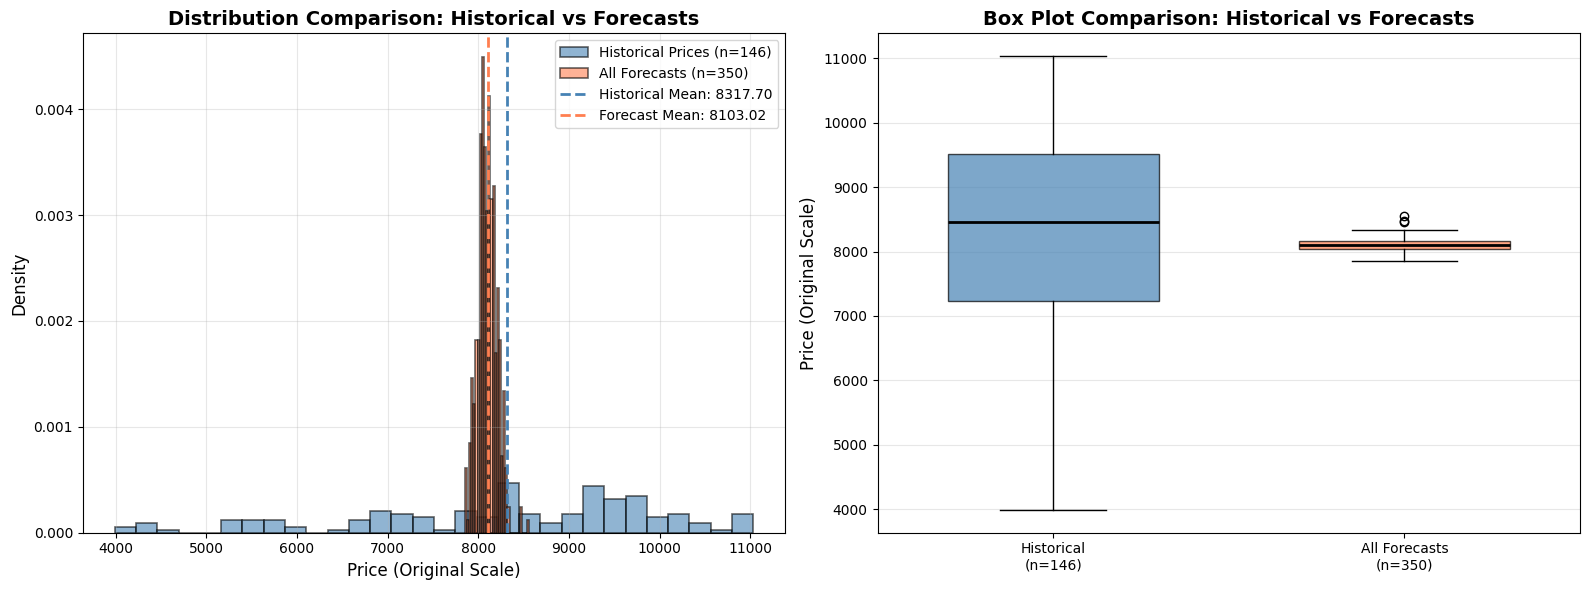

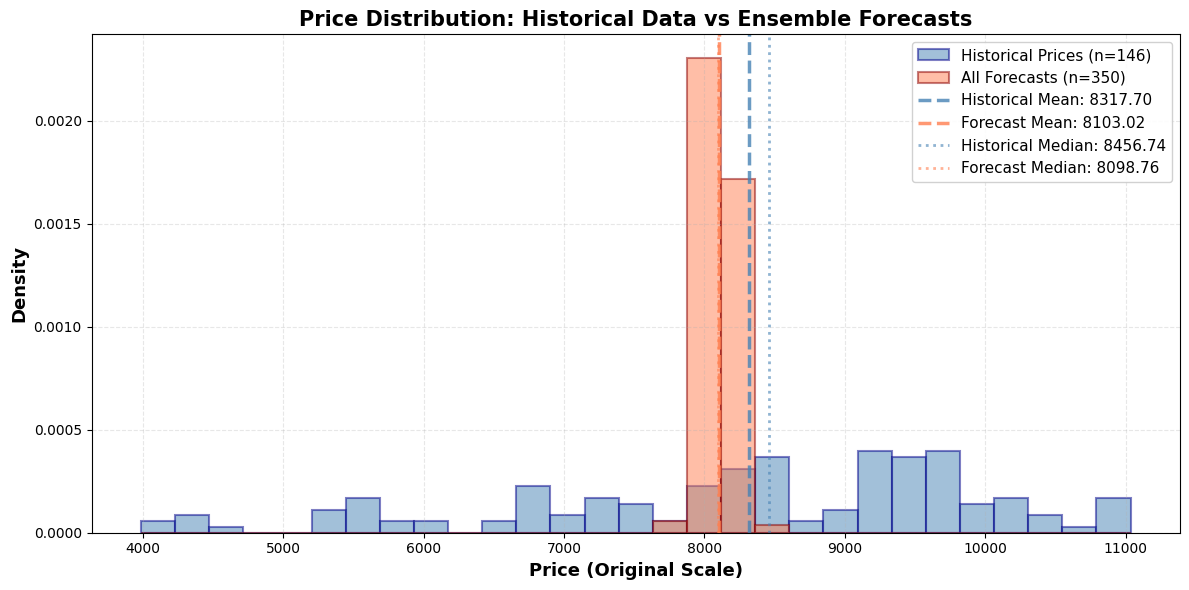

In [7]:
# Histogram comparing forecast distribution vs historical price distribution

import matplotlib.pyplot as plt
import numpy as np

# Collect all forecast values from all individual models (already inverse transformed)
all_forecast_values = []
for forecast_result in probabilistic_forecast_inverse.individual_forecasts:
    all_forecast_values.extend(forecast_result.forecast)

# Get historical price data (original scale, not scaled)
historical_prices = combined["price"].dropna().values

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Overlaid histograms
ax1 = axes[0]
ax1.hist(
    historical_prices, 
    bins=30, 
    alpha=0.6, 
    label=f'Historical Prices (n={len(historical_prices)})', 
    color='steelblue',
    density=True,
    edgecolor='black',
    linewidth=1.2
)
ax1.hist(
    all_forecast_values, 
    bins=30, 
    alpha=0.6, 
    label=f'All Forecasts (n={len(all_forecast_values)})', 
    color='coral',
    density=True,
    edgecolor='black',
    linewidth=1.2
)

# Add vertical lines for means
hist_mean = np.mean(historical_prices)
forecast_mean = np.mean(all_forecast_values)
ax1.axvline(hist_mean, color='steelblue', linestyle='--', linewidth=2, label=f'Historical Mean: {hist_mean:.2f}')
ax1.axvline(forecast_mean, color='coral', linestyle='--', linewidth=2, label=f'Forecast Mean: {forecast_mean:.2f}')

ax1.set_xlabel('Price (Original Scale)', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title('Distribution Comparison: Historical vs Forecasts', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Right plot: Side-by-side box plots
ax2 = axes[1]
box_data = [historical_prices, all_forecast_values]
box_labels = [f'Historical\n(n={len(historical_prices)})', f'All Forecasts\n(n={len(all_forecast_values)})']
bp = ax2.boxplot(box_data, labels=box_labels, patch_artist=True, widths=0.6)

# Color the boxes
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][0].set_alpha(0.7)
bp['boxes'][1].set_facecolor('coral')
bp['boxes'][1].set_alpha(0.7)

# Color the medians
for median in bp['medians']:
    median.set_color('black')
    median.set_linewidth(2)

ax2.set_ylabel('Price (Original Scale)', fontsize=12)
ax2.set_title('Box Plot Comparison: Historical vs Forecasts', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add statistics text
stats_text = f"""
Statistics Comparison:

Historical Prices:
  Mean: {np.mean(historical_prices):.2f}
  Median: {np.median(historical_prices):.2f}
  Std: {np.std(historical_prices):.2f}
  Min: {np.min(historical_prices):.2f}
  Max: {np.max(historical_prices):.2f}

All Forecasts:
  Mean: {np.mean(all_forecast_values):.2f}
  Median: {np.median(all_forecast_values):.2f}
  Std: {np.std(all_forecast_values):.2f}
  Min: {np.min(all_forecast_values):.2f}
  Max: {np.max(all_forecast_values):.2f}
"""

print(stats_text)

plt.tight_layout()
plt.show()

# Additional: Create a single combined histogram with better styling
fig2, ax3 = plt.subplots(figsize=(12, 6))

# Create histogram with better binning
n_bins = max(30, int(np.sqrt(len(historical_prices)) + np.sqrt(len(all_forecast_values))))
bins = np.linspace(
    min(np.min(historical_prices), np.min(all_forecast_values)),
    max(np.max(historical_prices), np.max(all_forecast_values)),
    n_bins
)

ax3.hist(
    historical_prices, 
    bins=bins, 
    alpha=0.5, 
    label=f'Historical Prices (n={len(historical_prices)})', 
    color='steelblue',
    density=True,
    edgecolor='darkblue',
    linewidth=1.5
)
ax3.hist(
    all_forecast_values, 
    bins=bins, 
    alpha=0.5, 
    label=f'All Forecasts (n={len(all_forecast_values)})', 
    color='coral',
    density=True,
    edgecolor='darkred',
    linewidth=1.5
)

# Add mean lines
ax3.axvline(hist_mean, color='steelblue', linestyle='--', linewidth=2.5, 
            label=f'Historical Mean: {hist_mean:.2f}', alpha=0.8)
ax3.axvline(forecast_mean, color='coral', linestyle='--', linewidth=2.5, 
            label=f'Forecast Mean: {forecast_mean:.2f}', alpha=0.8)

# Add median lines
hist_median = np.median(historical_prices)
forecast_median = np.median(all_forecast_values)
ax3.axvline(hist_median, color='steelblue', linestyle=':', linewidth=2, 
            label=f'Historical Median: {hist_median:.2f}', alpha=0.6)
ax3.axvline(forecast_median, color='coral', linestyle=':', linewidth=2, 
            label=f'Forecast Median: {forecast_median:.2f}', alpha=0.6)

ax3.set_xlabel('Price (Original Scale)', fontsize=13, fontweight='bold')
ax3.set_ylabel('Density', fontsize=13, fontweight='bold')
ax3.set_title('Price Distribution: Historical Data vs Ensemble Forecasts', fontsize=15, fontweight='bold')
ax3.legend(loc='best', fontsize=11, framealpha=0.9)
ax3.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()


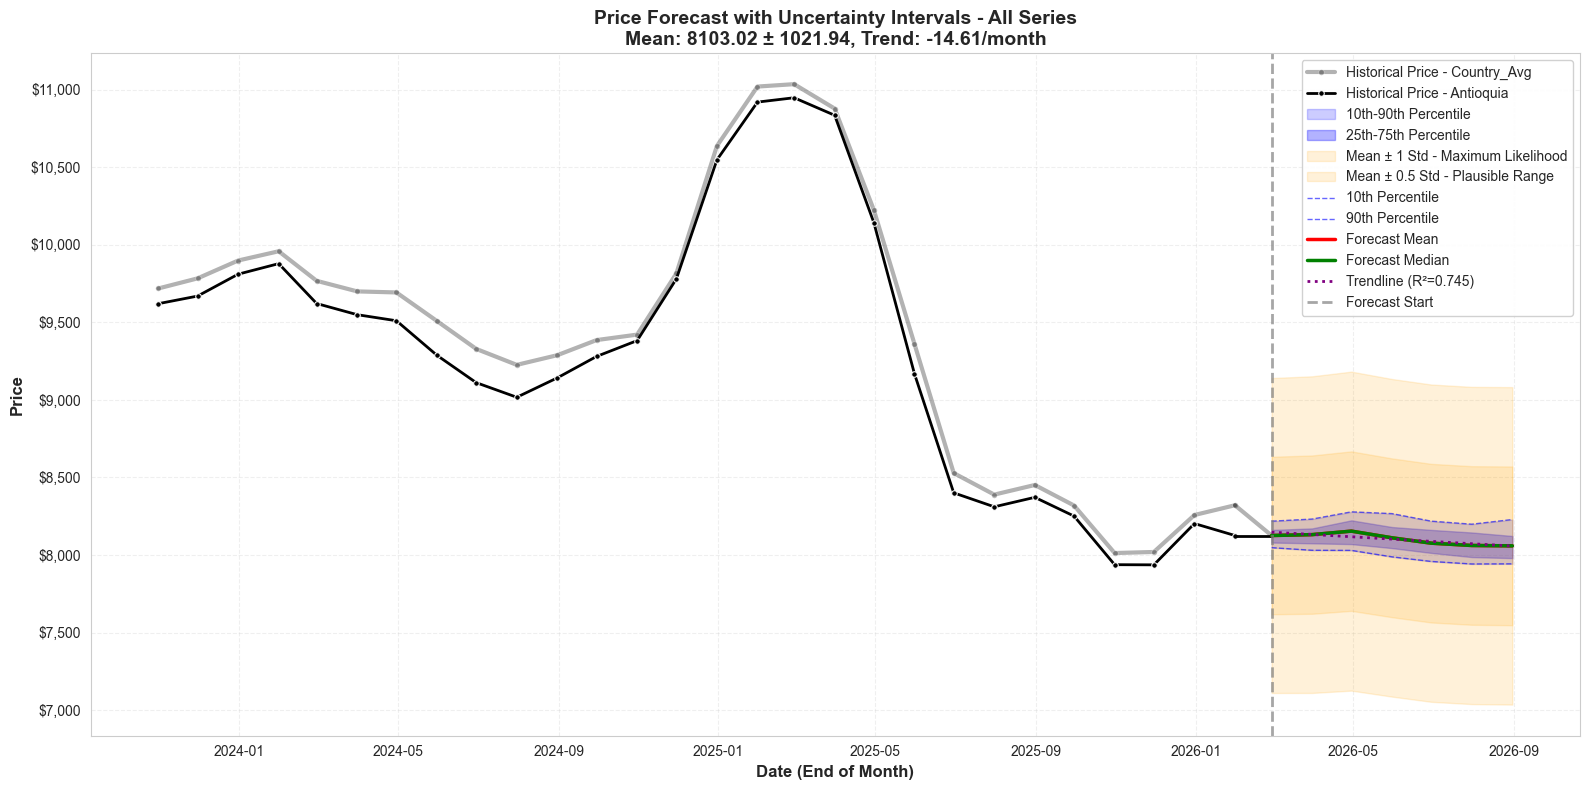


Forecast Summary Statistics
Number of series: 2
Forecast period: 7 months

Forecast Statistics (across all dates):
  Mean: 8103.02 ± 1021.94
  Median: 8103.02
  Min (10th percentile): 7942.59
  Max (90th percentile): 8278.50
  Trend slope: -14.61 per month
  Trend R²: 0.7454
  Trend p-value: 0.0123


In [8]:
# Comprehensive line plot with historical data, forecast quantiles, mean, median, std, and trendline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from pandas.tseries.offsets import MonthEnd

# Set seaborn style
sns.set_style("whitegrid")
sns.set_palette("husl")

# Prepare historical data
historical_df = combined[["eom", "price", "series_id"]].copy()
historical_df["eom"] = pd.to_datetime(historical_df["eom"])

std_multiplier = 1
# Prepare forecast data
forecast_dates = pd.to_datetime(probabilistic_forecast_inverse.dates)
forecast_df = pd.DataFrame({
    "eom": forecast_dates,
    "mean": probabilistic_forecast_inverse.mean,
    "median": probabilistic_forecast_inverse.median,
    "std": probabilistic_forecast_inverse.std,
    "quantile_10": probabilistic_forecast_inverse.quantiles.get("0.1", []),
    "quantile_25": probabilistic_forecast_inverse.quantiles.get("0.25", []),
    "quantile_50": probabilistic_forecast_inverse.quantiles.get("0.5", []),
    "quantile_75": probabilistic_forecast_inverse.quantiles.get("0.75", []),
    "quantile_90": probabilistic_forecast_inverse.quantiles.get("0.9", []),
})

# Calculate upper and lower bounds for std
forecast_df["mean_plus_std"] = forecast_df["mean"] + (forecast_df["std"] * std_multiplier)
forecast_df["mean_minus_std"] = forecast_df["mean"] - (forecast_df["std"] * std_multiplier)

forecast_df["mean_plus_n_std"] = forecast_df["mean"] + (forecast_df["std"] * std_multiplier / 2)
forecast_df["mean_minus_n_std"] = forecast_df["mean"] - (forecast_df["std"] * std_multiplier / 2)

# Get unique series
unique_series = historical_df["series_id"].unique()
n_series = len(unique_series)

# Create a single figure for all series
fig, ax = plt.subplots(figsize=(16, 8))

historical_multiplier = 4

# Calculate trendline using only forecast mean (once for all series)
forecast_date_numeric = (forecast_df["eom"] - forecast_df["eom"].min()).dt.days.values
trend_slope, trend_intercept, r_value, p_value, std_err = stats.linregress(
    forecast_date_numeric, forecast_df["mean"]
)
trendline = trend_slope * forecast_date_numeric + trend_intercept

# Plot historical data for all series on the same chart
for series_id in unique_series:
    # Filter historical data for this series
    series_historical = historical_df[historical_df["series_id"] == series_id].copy()
    series_historical = series_historical.sort_values("eom")
    
    # Set alpha based on series_id: Country_Avg is semi-transparent, Antioquia is prominent
    if series_id == "Country_Avg":
        alpha = 0.3
        linewidth = 3
    else:  # Antioquia or other series
        alpha = 1.0
        linewidth = 2
    
    # Plot historical data
    sns.lineplot(
        data=series_historical.iloc[-int(len(forecast_df.index) * historical_multiplier):],
        x="eom",
        y="price",
        ax=ax,
        label=f"Historical Price - {series_id}",
        linewidth=linewidth,
        marker="o",
        markersize=4,
        alpha=alpha,
        color="black"
    )
    
    # Connect historical price to first forecast mean value
    last_historical_date = series_historical["eom"].max()
    last_historical_price = series_historical["price"].iloc[-1]
    first_forecast_date = forecast_df["eom"].iloc[0]
    first_forecast_mean = forecast_df["mean"].iloc[0]
    
    # Draw connecting line
    ax.plot(
        [last_historical_date, first_forecast_date],
        [last_historical_price, first_forecast_mean],
        linewidth=linewidth,
        alpha=alpha,
        linestyle="-",
        color="black"
    )

# Plot forecast elements (only once, not per series)
# 10th-90th percentile region
ax.fill_between(
    forecast_df["eom"],
    forecast_df["quantile_10"],
    forecast_df["quantile_90"],
    alpha=0.2,
    color="blue",
    label="10th-90th Percentile"
)

# 25th-75th percentile region
ax.fill_between(
    forecast_df["eom"],
    forecast_df["quantile_25"],
    forecast_df["quantile_75"],
    alpha=0.3,
    color="blue",
    label="25th-75th Percentile"
)
    
ax.fill_between(
    forecast_df["eom"],
    forecast_df["mean_minus_std"],
    forecast_df["mean_plus_std"],
    alpha=0.15,
    color="orange",
    label=f"Mean ± {std_multiplier} Std - Maximum Likelihood"
)

ax.fill_between(
    forecast_df["eom"],
    forecast_df["mean_minus_n_std"],
    forecast_df["mean_plus_n_std"],
    alpha=0.15,
    color="orange",
    label=f"Mean ± {std_multiplier / 2} Std - Plausible Range"
)

# Plot quantile lines
sns.lineplot(
    x=forecast_df["eom"],
    y=forecast_df["quantile_10"],
    ax=ax,
    color="blue",
    linestyle="--",
    linewidth=1,
    alpha=0.6,
    label="10th Percentile"
)
sns.lineplot(
    x=forecast_df["eom"],
    y=forecast_df["quantile_90"],
    ax=ax,
    color="blue",
    linestyle="--",
    linewidth=1,
    alpha=0.6,
    label="90th Percentile"
)

# Plot mean
sns.lineplot(
    x=forecast_df["eom"],
    y=forecast_df["mean"],
    ax=ax,
    color="red",
    linewidth=2.5,
    linestyle="-",
    label="Forecast Mean"
)

# Plot median
sns.lineplot(
    x=forecast_df["eom"],
    y=forecast_df["median"],
    ax=ax,
    color="green",
    linewidth=2.5,
    linestyle="-",
    label="Forecast Median"
)

# Plot trendline (only for forecast period)
sns.lineplot(
    x=forecast_df["eom"],
    y=trendline,
    ax=ax,
    color="purple",
    linewidth=2,
    linestyle=":",
    label=f"Trendline (R²={r_value**2:.3f})"
)

# Add vertical line to separate historical and forecast
first_forecast_date = forecast_df["eom"].iloc[0]
ax.axvline(
    x=first_forecast_date,
    color="gray",
    linestyle="--",
    linewidth=2,
    alpha=0.7,
    label="Forecast Start"
)

# Formatting
ax.set_xlabel("Date (End of Month)", fontsize=12, fontweight="bold")
ax.set_ylabel("Price", fontsize=12, fontweight="bold")
ax.set_title(
    f"Price Forecast with Uncertainty Intervals - All Series\n"
    f"Mean: {forecast_df['mean'].mean():.2f} ± {forecast_df['std'].mean():.2f}, "
    f"Trend: {trend_slope*30:.2f}/month",
    fontsize=14,
    fontweight="bold"
)
ax.legend(loc="best", fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle="--")

# Format y-axis to show currency
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x:,.0f}"))

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("Forecast Summary Statistics")
print("="*80)
print(f"Number of series: {n_series}")
print(f"Forecast period: {len(forecast_df)} months")
print(f"\nForecast Statistics (across all dates):")
print(f"  Mean: {forecast_df['mean'].mean():.2f} ± {forecast_df['std'].mean():.2f}")
print(f"  Median: {forecast_df['median'].mean():.2f}")
print(f"  Min (10th percentile): {forecast_df['quantile_10'].min():.2f}")
print(f"  Max (90th percentile): {forecast_df['quantile_90'].max():.2f}")
print(f"  Trend slope: {trend_slope*30:.2f} per month")
print(f"  Trend R²: {r_value**2:.4f}")
print(f"  Trend p-value: {p_value:.4f}")
print("="*80)
